In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
r1 =np.sqrt(0.33/np.pi)
r2 = np.sqrt((0.33/np.pi+r1**2))
r1, r2

(0.32410224072142874, 0.4583497844237541)

In [8]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [9]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [10]:
%%time
path_figs = './figs/20kstd5/'
save = True
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 137 µs, sys: 116 µs, total: 253 µs
Wall time: 337 µs


In [11]:
%%time

N,D = 2*10**4, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.5,0.5],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.122]*5
r_big = [0.2,0.2,0.2, 0.2,0.2]
kw_cluster =  {'f_class_name':'circle_class3', 'centers': centers, 'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [0, std],[0, std],
                  [0, std],[1, std],[1, std],[2, std],[3, std],[4, std],[5, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:121, Number of Points:20000
CPU times: user 56.1 ms, sys: 12.5 ms, total: 68.6 ms
Wall time: 62.5 ms


In [12]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,0,0,3.046737,-0.670012,-3.716749
1,0.602763,0.544883,0,0,-12.710297,8.679807,21.390104
2,0.423655,0.645894,2,0,5.168985,-11.989884,-17.158869
3,0.437587,0.891773,0,0,3.842964,1.617715,-2.225249
4,0.963663,0.383442,0,0,1.522925,15.902760,14.379835


In [13]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.495176,0.500139,1.130250,0.502900,1.177638,1.221437,1.102429
std,0.289365,0.289445,1.721346,0.500004,5.101396,5.149392,7.263410
min,0.000072,0.000074,0.000000,0.000000,-19.500127,-23.260588,-28.349920
25%,0.243445,0.248979,0.000000,0.000000,-2.284797,-2.274898,-3.771657
50%,0.495403,0.499194,0.000000,1.000000,1.164745,1.197306,1.092328
75%,0.743434,0.754316,2.000000,1.000000,4.597291,4.645637,5.953737
max,0.999962,0.999978,5.000000,1.000000,23.834711,21.010989,30.715434


In [14]:
data['C'].value_counts()/len(data)

0    0.63500
5    0.07995
4    0.07755
3    0.07745
1    0.07215
2    0.05790
Name: C, dtype: float64

In [15]:
data.groupby('C').ITE.mean()

C
0   -0.045744
1    0.634630
2    2.013104
3    3.164988
4    4.040733
5    5.136234
Name: ITE, dtype: float64

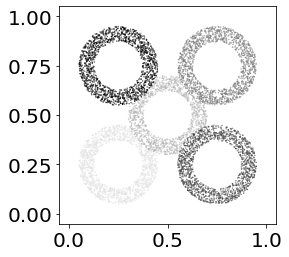

In [16]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [17]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [18]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 28.7 s, sys: 48.3 ms, total: 28.8 s
Wall time: 28.8 s


In [19]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,0,0,3.046737,-0.670012,-3.716749,0,4.548414,1.501677
1,0.602763,0.544883,0,0,-12.710297,8.679807,21.390104,0,-0.807142,11.903154
2,0.423655,0.645894,2,0,5.168985,-11.989884,-17.158869,0,0.811861,-4.357124
3,0.437587,0.891773,0,0,3.842964,1.617715,-2.225249,0,1.339805,-2.503159
4,0.963663,0.383442,0,0,1.522925,15.902760,14.379835,0,-0.545735,-2.068660


### Model performance

In [20]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        0.951235  1.024067  1.065262  0.072832  0.114027
            1        1.056233  0.934178  0.938343 -0.122055 -0.117889
          1 0        0.072603  0.905440  0.697709  0.832837  0.625106
            1        0.534920  0.767547  0.840009  0.232627  0.305088
          2 0        0.060879  1.968898  1.769256  1.908019  1.708377
            1        0.137725  2.954448  1.556451  2.816724  1.418727
          3 0        0.079165  2.888295  2.793313  2.809129  2.714147
            1       -0.262454  3.420086  2.882062  3.682540  3.144516
          4 0       -0.288326  3.990599  3.119578  4.278926  3.407904
            1        0.039704  4.414552  3.340155  4.374848  3.300451
          5 0       -0.142993  5.120292  5.018579  5.263285  5.161573
            1        0.416814  5.292075  4.719609  4.875261  4.302795
1         0 0        0.840710  0.902636  0.797058 -0.061926  0.043652
            1        1.004261  1.382547  0.861360 -0.378286  0.142902
          1 0        0.815735  0.374744  0.185759  0.440991  0.629976
            1        1.017310  0.048738  0.247057  0.968572  0.770253
          2 0        1.871215 -0.025616  0.117110  1.896831  1.754105
            1        2.422699  0.435774  0.531081  1.986926  1.891619
          3 0        3.274880 -0.089694  0.221647  3.364574  3.053232
            1        3.371341  0.092849 -0.233486  3.278492  3.604827
          4 0        3.791192  0.095112 -0.163896  3.696080  3.955088
            1        4.347821  0.054934  0.610120  4.292887  3.737702
          5 0        5.225139  0.444389 -0.190172  4.780750  5.415311
            1        5.585768 -0.634153  0.280420  6.219921  5.305348

### Apply clustering Box and Kmeans

In [21]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 30min 20s, sys: 1.44 s, total: 30min 22s
Wall time: 52.8 s


In [22]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,3.046737,-0.670012,-3.716749,0,4.548414,1.501677,83,116
1,0.602763,0.544883,0,0,-12.710297,8.679807,21.390104,0,-0.807142,11.903154,61,103
2,0.423655,0.645894,2,0,5.168985,-11.989884,-17.158869,0,0.811861,-4.357124,81,48
3,0.437587,0.891773,0,0,3.842964,1.617715,-2.225249,0,1.339805,-2.503159,103,87
4,0.963663,0.383442,0,0,1.522925,15.902760,14.379835,0,-0.545735,-2.068660,54,20


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [23]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [24]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.127157,151.0,1.000000,0.00755
1,1,-0.039208,179.0,0.877095,0.00895
2,2,-0.777620,129.0,0.620155,0.00645


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


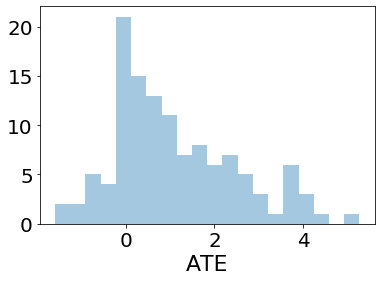

In [25]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 20
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, bins=bins, kde = False,ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


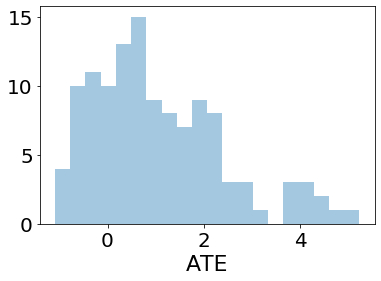

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], 
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


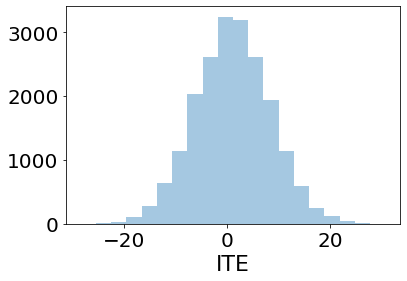

In [27]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = bins,
                  kde = kde, ax = ax)
ax.set_xlabel('ITE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [28]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,121.000000,121.000000,121.000000,121.000000,121.000000
mean,60.000000,1.108234,165.289256,0.790662,0.008264
std,35.073732,1.392077,13.062949,0.179433,0.000653
min,0.000000,-1.600797,129.000000,0.421053,0.006450
25%,30.000000,0.075505,156.000000,0.633333,0.007800
50%,60.000000,0.778941,166.000000,0.818792,0.008300
75%,90.000000,2.082507,175.000000,0.988950,0.008750
max,120.000000,5.275196,206.000000,1.000000,0.010300


### Calculate ATT per Cluster not known Model Calculated CF

In [29]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


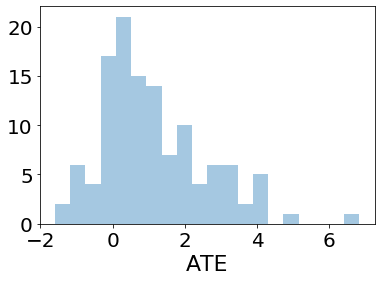

In [30]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'],bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
#ax.set_xlim(-0.5,2.5)
if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


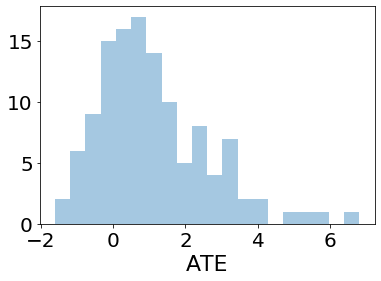

In [31]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], 
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
#ax.set_xlim(-1,2.5)
if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


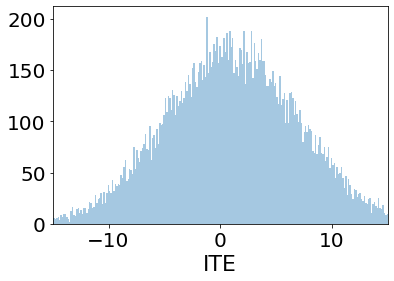

In [32]:
fig, ax = plt.subplots(1,1)
bins = 400
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ITE')
#ax.set_ylabel('weight')
ax.set_xlim(-15,15)
if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Optimal 3-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [33]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 7
val = 6
for i, (dd, name, name2,w) in enumerate(zip(all_data, names_to_give, names_to_find,weights)):
    all_data[i], _ = optimal_clustering(dd, max_clusters = clusts, col_select = name2, 
                      cluster_name = name, N=N, val = val )
    


Did not pick 6, it picked: 3
Did not pick 6, it picked: 3
Did not pick 6, it picked: 4
Did not pick 6, it picked: 4
CPU times: user 876 ms, sys: 36 ms, total: 912 ms
Wall time: 976 ms


In [34]:
box['Box-Cl2'].value_counts()

1    36
2    28
4    19
3    16
5    12
0    10
Name: Box-Cl2, dtype: int64

In [35]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.127157,151.0,1.000000,0.00755,1
1,1,-0.039208,179.0,0.877095,0.00895,1


In [36]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,0,0,3.046737,-0.670012,-3.716749,0,4.548414,1.501677,83,116
1,0.602763,0.544883,0,0,-12.710297,8.679807,21.390104,0,-0.807142,11.903154,61,103


### 3 Clustering in the ITEs

In [37]:
cluster_name1 = 'ITE-2CTrue'
col1 = 'ITE'
filt11 = data2[col1] <= 0.5
filt21 = data2[col1] >= 0.5
filt31 = data2[col1] >= 1.5
filt41 = data2[col1] >= 2.5
filt51 = data2[col1] >= 3.5
filt61 = data2[col1] >= 4.5

data2[cluster_name1] = 0
data2.loc[filt11,cluster_name1] = 0
data2.loc[filt21, cluster_name1] = 1
data2.loc[filt31, cluster_name1] = 2
data2.loc[filt41,cluster_name1] = 3
data2.loc[filt51, cluster_name1] = 4
data2.loc[filt61, cluster_name1] = 5

cluster_name2 = 'ITE-2CGDBR'
col2 = 'ITE-GDBR'
filt12 = data2[col2] <= 0.5
filt22 = data2[col2] >= 0.5
filt32 = data2[col2] >= 1.5
filt42 = data2[col2] >= 2.5
filt52 = data2[col2] >= 3.5
filt62 = data2[col2] >= 4.5


data2[cluster_name2] = 0
data2.loc[filt12,cluster_name2] = 0
data2.loc[filt22, cluster_name2] = 1
data2.loc[filt32, cluster_name2] = 2
data2.loc[filt42,cluster_name2] = 3
data2.loc[filt52, cluster_name2] = 4
data2.loc[filt62, cluster_name2] = 5


#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [38]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [39]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,0,0,3.046737,-0.670012,-3.716749,0,4.548414,1.501677,83,116,0,2,4,4,3,4
1,0.602763,0.544883,0,0,-12.710297,8.679807,21.390104,0,-0.807142,11.903154,61,103,5,5,1,1,1,2


### Plot reconstruction of data

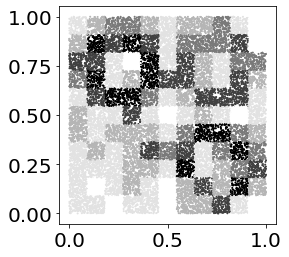

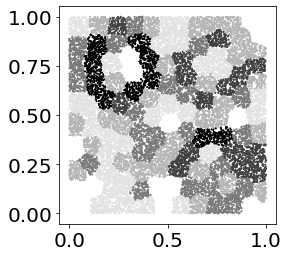

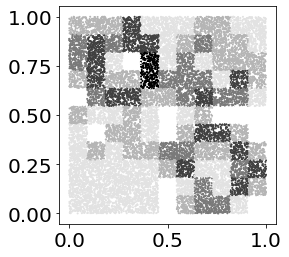

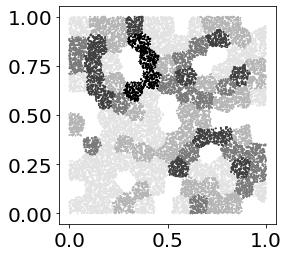

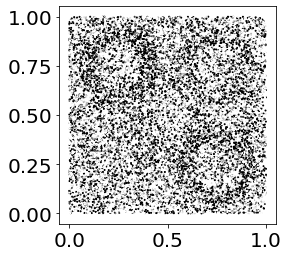

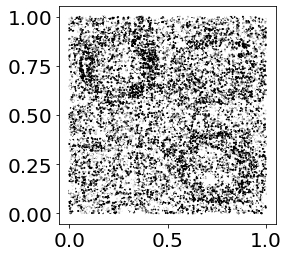

CPU times: user 8.55 s, sys: 263 ms, total: 8.81 s
Wall time: 8.79 s


In [40]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [41]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [42]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [43]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [44]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [45]:
errors.sort_values(by = 'mean')

,mean,std
Box-Cl2-err-GDBR,0.946144,0.923694
Box-Cl2-err-True-ITE,0.953412,0.949497
Kmeans-Cl2-err-GDBR,0.983763,0.956354
Kmeans-Cl2-err-True-ITE,1.004873,0.943441
Box2-Cl2-err-True-ITE,1.025476,0.939386
Kmeans2-Cl2-err-True-ITE,1.044256,0.943143
Box2-Cl2-err-GDBR,1.072761,0.952760
Kmeans2-Cl2-err-GDBR,1.105688,0.958283
ITE-2CTrue-err-GDBR,2.884840,1.700957
ITE-2CGDBR-err-True-ITE,3.442443,1.836310


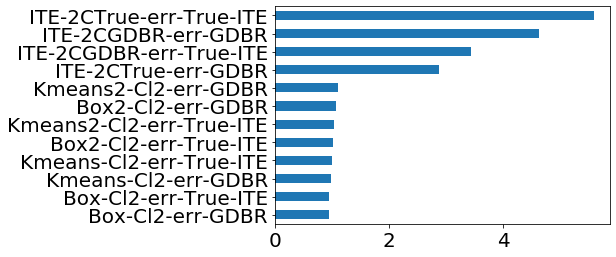

In [46]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [47]:
from evaluations import confusion_matrix
    

In [48]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)
for name in class_names2:
    mat = confusion_matrix(data2, 'C', name,6, save = True, save_dir = path4)
    print(name)
    display(mat)

Box-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.112677,0.412598,0.254724,0.114094,0.080866,0.025039
C1 True,0.132363,0.377685,0.432432,0.000000,0.057519,0.000000
C2 True,0.000000,0.102763,0.281520,0.223661,0.329016,0.063040
C3 True,0.009684,0.009038,0.102001,0.319561,0.559716,0.000000
C4 True,0.000000,0.040619,0.144423,0.152805,0.252740,0.409413
C5 True,0.000625,0.003752,0.039400,0.129456,0.253909,0.572858


Kmeans-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.165669,0.316772,0.274724,0.140000,0.078346,0.024488
C1 True,0.138600,0.311850,0.284823,0.264726,0.000000,0.000000
C2 True,0.000000,0.042314,0.303109,0.573402,0.047496,0.033679
C3 True,0.000000,0.027760,0.320852,0.169787,0.481601,0.000000
C4 True,0.003868,0.000000,0.096067,0.361702,0.359768,0.178594
C5 True,0.006254,0.005003,0.048780,0.150094,0.105691,0.684178


Box2-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.149764,0.420394,0.266850,0.102835,0.057559,0.002598
C1 True,0.047124,0.634789,0.318087,0.000000,0.000000,0.000000
C2 True,0.025043,0.125216,0.465458,0.301382,0.056995,0.025907
C3 True,0.000000,0.020013,0.377017,0.443512,0.159458,0.000000
C4 True,0.000000,0.124436,0.131528,0.284333,0.459703,0.000000
C5 True,0.000625,0.000625,0.124453,0.155722,0.547842,0.170732


Kmeans2-Cl2


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.276220,0.362362,0.213701,0.090551,0.051260,0.005906
C1 True,0.048510,0.611920,0.248094,0.091476,0.000000,0.000000
C2 True,0.000000,0.264249,0.473230,0.216753,0.015544,0.030225
C3 True,0.003873,0.118786,0.328599,0.313105,0.235636,0.000000
C4 True,0.011605,0.058027,0.309478,0.307544,0.313346,0.000000
C5 True,0.006254,0.048155,0.138837,0.101313,0.347717,0.357724


ITE-2CTrue


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.531024,0.054567,0.053622,0.054173,0.047008,0.259606
C1 True,0.479556,0.068607,0.054054,0.062370,0.051282,0.284130
C2 True,0.412781,0.050086,0.056995,0.054404,0.065630,0.360104
C3 True,0.347321,0.061975,0.062621,0.058102,0.052937,0.417043
C4 True,0.297228,0.060606,0.059317,0.056738,0.058027,0.468085
C5 True,0.263915,0.051907,0.048155,0.052533,0.053158,0.530331


ITE-2CGDBR


,C0 Pred,C1 Pred,C2 Pred,C3 Pred,C4 Pred,C5 Pred
C0 True,0.533071,0.066850,0.061496,0.061496,0.054882,0.222205
C1 True,0.489951,0.069993,0.063756,0.073458,0.058905,0.243936
C2 True,0.411054,0.074266,0.075993,0.056131,0.063903,0.318653
C3 True,0.331181,0.070368,0.067140,0.069077,0.072305,0.389929
C4 True,0.288846,0.056093,0.068988,0.062540,0.072211,0.451322
C5 True,0.213884,0.055660,0.055034,0.068793,0.063164,0.543465


In [49]:
data2.groupby('ITE-2CGDBR').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2-err-GDBR,Kmeans-Cl2-err-GDBR,Box2-Cl2-err-GDBR,Kmeans2-Cl2-err-GDBR,ITE-2CTrue-err-GDBR,ITE-2CGDBR-err-GDBR,Box-Cl2-err-True-ITE,Kmeans-Cl2-err-True-ITE,Box2-Cl2-err-True-ITE,Kmeans2-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE,ITE-2CGDBR-err-True-ITE
ITE-2CGDBR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.492519,0.488567,0.723855,0.494382,1.028717,1.167517,-2.774686,0.201707,0.873287,-4.076492,58.639693,60.241357,1.019663,2.017502,1.970830,1.691551,1.496003,0.861606,0.900264,0.989725,1.022775,2.699468,4.800347,0.879709,0.926715,0.931145,0.949300,5.319879,3.498541
1,0.492394,0.485801,1.054504,0.521575,1.090907,1.162998,0.952788,0.196064,1.053013,0.984829,58.124148,61.960636,1.980318,2.226344,2.215746,1.887964,1.705526,0.928665,0.986783,1.066165,1.109878,2.872323,1.335564,0.932106,1.004584,1.024178,1.042862,5.368263,1.326420
2,0.494329,0.507758,1.149206,0.523016,1.117125,1.206115,1.722054,0.223810,1.019330,2.000992,60.895238,60.656349,2.211905,2.288889,2.238889,1.952381,1.789683,0.951803,0.971712,1.065787,1.097998,2.980798,1.775125,0.956618,0.988303,1.027585,1.039691,5.523656,1.667395
3,0.495510,0.505475,1.180885,0.507899,1.117609,1.305967,2.544118,0.188784,1.072192,2.996592,60.721169,58.448657,2.571090,2.385466,2.349921,2.009479,1.854660,0.966890,1.014081,1.066660,1.105590,3.096076,2.318188,0.974595,1.034175,1.019555,1.044917,5.627826,2.090164
4,0.496989,0.506764,1.288738,0.536833,1.313441,1.176838,3.407747,0.190517,1.029995,3.971920,60.760373,60.509738,2.827265,2.357324,2.331922,2.038103,1.903472,0.955675,1.017658,1.109804,1.146884,3.075710,2.864352,0.956130,1.035246,1.078878,1.104376,5.713544,2.503682
5,0.499858,0.517960,1.757698,0.499825,1.437410,1.316126,6.483074,0.197341,1.499172,8.352334,62.141882,57.906578,3.659027,2.662526,2.653079,2.295136,2.193492,1.079266,1.107215,1.203984,1.232186,3.080536,6.594637,1.071723,1.122390,1.168339,1.186778,6.046948,4.725376


In [50]:
np.mean(np.abs(data2['C'] - data2['ITE-GDBR'])), np.std(np.abs(data2['C'] - data2['ITE-GDBR']))

(4.638318015664944, 3.5203038770668647)